In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import random
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from multiprocessing import Pool, cpu_count
ncpus = cpu_count()

import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter,DayLocator
import matplotlib.dates as mdates
from IPython.display import display

sys.path.append(os.path.abspath('../../code/classification'))
from utils.entropy import *
from utils.util import *

print "Pandas version:", pd.__version__
print "Sklearn version:", sklearn.__version__

In [ ]:
## LOAD DATA
# load dataframe from file
#df = load_data('loc1.pickle')
df = load_data(path=os.path.join(DATA_DIR, 'loc1'));

In [12]:
## SELECT SUBSET OF INSTANCES
# take only instances collected in vms (discard rpi instances)
df = df[df.name == 'loc1'].copy()

# remove possible errors
df = min_inst(df, n=1.0)  # remove sites with less than one instance
#df = std_thres(df, th=5.0)  # remove sites that have more than 5 packets std

# discard traces that have less than one packet
df['num_pkts'] = df.lengths.apply(len)
df = df[df.num_pkts > 3]

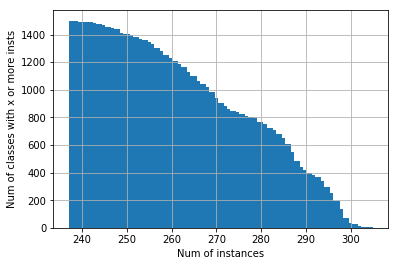

[476.036776063654, 488.31813911509505, 500.0020726777298, 510.40478486168763, 519.1389883268483, 528.7020738210589, 534.7169824173018, 524.0156732433368, 368.68363636363614, 0]
Optimal number of instances: 277
Optimal number of classes: 811


In [15]:
# histogram num of instances per class
opt_num_insts, opt_num_classes = optimal_instances_per_class(df, draw=True)

In [16]:
# Number of instances per class
NUM_INSTS = 60
NUM_CLASSES = 1500

In [17]:
df = trim_sample_df(df, NUM_INSTS, NUM_CLASSES)

# Entropy of websites given $k$ observed packets

## Definitions

A packet size sequence is a finite sequence of non-zero integers: $(s_i)_{i=1}^n, s_i\in \mathbb{Z}\smallsetminus\{0\}, n\in \mathbb{N}$. In an abuse of notation, we may denote such a sequence as  just $s$.

We assume there is a fix closed-world of $m$ websites: $w_1, \ldots, w_m$. For each website $w_i$, we assume there are only $k_i$ possible sequences of packet sizes: $w_i = \{s_{i,1}, \ldots, s_{i, k_i}\}$, where $s_{i, j}$ denotes the $j$-th sequence of packet sizes for website $w_i$. 

We define the anonymity _set_ of a packet sequence $s$ as a multiset:

$$ A(s) := \{w^{\mbox{m}_s(w)}\},$$

where $\mbox{m}_s(w)$ is the multiplicity of a website $w$ in $A(s)$. The multiplicity is a function defined as the number of times that sequence $s$ occurrs in $w$, i.e., $\mbox{m}_s(w) := |\{s_j\in w : s_j = s\}|$.

### Probability space

We define sample spaces: $\Omega_W := \{w_i : i=1,\ldots, m\}$ and $\Omega_S := \{s_{i,j} : i=1,\ldots, m, j=k_1,\ldots, k_m\}$ and their corresponding random variables $W$ and $S$, respectively.

As an example of a probability based on these two random variables, the probabilitiy of website $w$ given that we have observed a trace $t$ is:

$$P(W=w \mid S=s)$$

If we want to express probabilities in terms of *number of observed packets*, we could define the sample space $\Omega_{S_l} := \{(s_i)_{i=1}^l \mid l < n\}$, denoting samples of length-$l$ subsequences, i.e., $l$ packet sizes from  the packet size sequences in $\Omega_S$. $S_l$ is the corresponding random variable for $\Omega_{S_l}$.

We can express the probability for having observed a sequence of $l$ packets as:

$$P(W=w\mid S_l = s)$$

As an example, for $l=2$, the probability of website $w$ given that we observed the first packet to be $s_1=88$ and the second $s_2=-64$ is:

$$P(W=w\mid S_2 = (88, -64))$$

In [18]:
# Create probability model
M = ProbabilityModel(df, l=7)

## show top anonymity sets A(s) for length l=7
anon_sets = M.rank()
#print anon_sets.filter(1).sort()

count    567.000000
mean      17.670194
std       32.132657
min        1.000000
25%        1.000000
50%        2.000000
75%       14.000000
max      152.000000
Name: class_label, dtype: float64


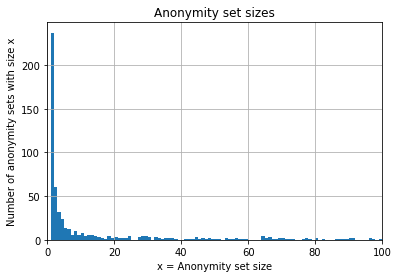

In [19]:
# anonymity set sizes for packet 2-7
df['pkt_subseq'] = df.lengths.apply(lambda x: tuple(x[2:7]))
num_sites = df.groupby('pkt_subseq').class_label.apply(lambda x: len(np.unique(x)))
print num_sites.describe()

num_sites.hist(bins=range(min(num_sites), max(num_sites)))

plt.xlim((0, 100))
plt.xlabel('x = Anonymity set size')
plt.ylabel('Number of anonymity sets with size x')
plt.title("Anonymity set sizes")
plt.show()

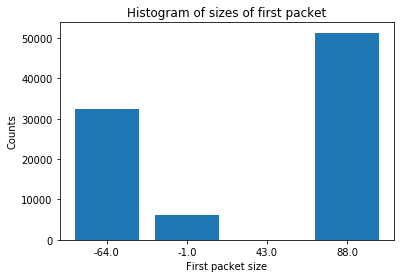

In [20]:
# first packet sizes:
first_packets = df.lengths.apply(lambda x: x[0])
values = sorted(list(set(first_packets)))
bins = values + [values[-1] + 1]
counts, _ = np.histogram(first_packets, bins=bins)
#print values, counts
values, counts = zip(*[(i, j) for i, j in zip(values, counts) if j > 2])
plt.bar(map(str, values), counts)
plt.xlabel('First packet size')
plt.ylabel('Counts')
plt.title("Histogram of sizes of first packet")
plt.show()

## Estimation of probabilities
Since our observations are the packet size sequences, each of these probabilities can be worked out using Bayes. For instance, for website $w$,

$$P(W=w\mid S_l=s) = \frac{P(W=w)P(S_l=s\mid W=w)}{\displaystyle\sum_{i=1}^m P(W=w_i)P(S_l=s\mid W=w_i)}$$

We estimate the priors and the likelihoods based on our dataset of observations.

Since it is hard to estimate the priors, we follow prior work and make the assumption that priors are uniform:

$$P(w_i) = P(w_j)\quad\forall i, j$$

Assuming uniform priors allows us to simplify the Bayes rule formula since we can factor out $P(w_i)$ from the Bayes equation and we end up having:

$$P(W=w\mid S_l=s) = \frac{P(S_l=s\mid W=w)}{\displaystyle\sum_{i=1}^m P(S_l=s\mid W=w_i)}$$

We estimate the likelihood as:

$$P(S_l=s\mid W=w_i) \approx \frac{\mbox{m}_s(w_i)}{k_i}$$


Since we have the a large number of samples for all the sites, we take the same sample size for all sites: $k_i = k_j\quad\forall i,j$, and we call $k$ that sample size.

A fixed sample size allows us to factor out $k$ and obtain that the posterior can be estimated as:

$$P(W=w\mid S_l=s) \approx \frac{\mbox{m}_s(w)}{\displaystyle\sum_{i=1}^m \mbox{m}_s(w_i)} = \frac{\mbox{m}_s(w)}{|A(s)|} $$

In [21]:
# EXAMPLE
## using the probability model, we compute the posterior for website google.com given a subsequence of sizes:
s = (-64.0, 88.0, 94.0, 61.0, 33.0, 33.0, -33.0)
w = str(alexa_rank('google.com'))

M.posterior.xs((s, w))  # P(W=w | S=s)

0.0068198133524766695

## Conditional entropy
For a given $s\in \Omega_{S_l}$, the entropy $H(W\mid S_l=s)$ are computed on the probability distribution of websites given $S=s$:

$$H(W\mid S_l=s) = -\displaystyle\sum_{i=1}^m P(W=w_i\mid S_l=s) \log P(W=w_i\mid S_l=s)$$

we take $\log$ with base $2$. This entropy reflects the bits of information that sequence $s$ reveals of a website.

Our ultimate goal is to compute the entropy of websites given an observation of $l$ packets: $H(W\mid S_l)$. This captures how much information the observation of $l$ packets reveals about the websites. This conditional entropy is computed based on the samples taken from $\Omega_{S_l}$:

$$H(W\mid S_l) = \displaystyle\sum_{\forall s\in \Omega_{S_l}} P(S_l=s) H(W\mid S_l=s)$$

In [22]:
# EXAMPLE
## the conditional entropy H(W | S_l):
M.cond_entropy()

6.10550218313501

## Non-uniform priors

Fixing the sample size for all sites is fine as we have enough samples for each website for our estimations to be statistically significant (proof?). However, note that both prior and likelihood will be biased by the fact that we are not collecting DNS traffic from actual Internet users, but rather collecting it using an automated crawler.

Regarding the assumption of uniform priors, we can drop the assumption and model the priors according to a different distribution $f$:

$$P(w_i) \approx f(w_i)$$

For instance, let's say we want to model $P(w_i)$ as a geometric distribution on the Alexa rank of $w_i$. That would reflect that the top sites concentrate a large fraction of the total traffic volume (e.g., Google and Facebook). Then, we take $f$ to be the probability mass function of a Geometric distribution:

$$f(w_i)=p^{\mbox{r}(w_i)+1}$$

where $p$ is the probability of the top website ($w$ such that $\mbox{r}(w_i)=0$). We use $p=0.4$ because Google was estimated to receive 40% of all Internet traffic (https://www.cnet.com/news/google-goes-down-for-5-minutes-internet-traffic-drops-40/).

Then, the estimation of the posterior would be:

$$P(W=w\mid S_l=s) \approx \frac{F(w)}{\displaystyle\sum_{i=1}^m F(w_i)}\mbox{,}\quad\mbox{ where }\;F(w_i) := f(w_i)\;\mbox{m}_s(w_i) = p^{\mbox{r}(w_i)+1}\;\mbox{m}_s(w_i)$$

In [23]:
M.posterior = M.estimate_posterior(priors='geometric')

In [24]:
# EXAMPLE
## if we compute the posterior of google.com, with the new model it should be much larger:
s = (-64.0, 88.0, 94.0, 61.0, 33.0, 33.0, -33.0)
w = str(alexa_rank('google.com'))

M.posterior.xs((s, w))  # P(W=w | S=s)

0.92762467807258042

In [25]:
# the entropy should be lower because some sites are more likely than others
# and thus less information is needed to describe website given size.
M.cond_entropy()

0.1689865782527508

In [26]:
# entropies for the first top 100 sites compared to the last sites after rank 1000
# for two different distributions of priors

## with uniform priors
M100 = ProbabilityModel(df[df.class_label.isin(map(str, range(2)))], 3)
M1000 = ProbabilityModel(df[df.class_label.isin(map(str, range(3, 5)))], 3)

print "Uniform priors entropies:", "top-100:", M100.cond_entropy(), "1000-1100:", M1000.cond_entropy()

## with priors following a geometric distribution
M100.posterior = M100.estimate_posterior(priors='geometric')
M1000.posterior = M1000.estimate_posterior(priors='geometric')

print "Geometric priors entropies:", "top-100:", M100.cond_entropy(), "1000-1100:", M1000.cond_entropy()

Uniform priors entropies: top-100: 0.600309618361 1000-1100: 0.63174540591
Geometric priors entropies: top-100: 0.548677605504 1000-1100: 0.585290734295


Entropies for top sites for geometrically distributed priors are lower because the packet size sequences do not contribute as much information as if priors are uniform.

## Implementation

We have implementations for posterior estimation and entropy computation in `code/classification/entropy.py`.

# Graphs

## Entropy for different observed number of packets

In [408]:
%%time
LOAD_FROM_FILE = True

# Compute entropies for different sites
NSITES = [10, 100, 500, 1500]
POSITIONS = 50
SAMPLES = 10

def avg_entropies(i):
    entropies = np.zeros((SAMPLES, POSITIONS))
    for k in xrange(SAMPLES):
        # select a random sample of i sites
        classes = df.class_label.unique()
        selected = np.random.choice(classes, i, replace=False)
        df_sel = df[df.class_label.isin(selected)].copy()
        entropies[k, :] = [ProbabilityModel(df_sel, l=j + 1).cond_entropy() for j in xrange(POSITIONS)]
    #avg_entropies = np.mean(entropies, axis=0)
    return entropies

if not LOAD_FROM_FILE:
    # multiprocessing
    p = Pool(len(NSITES))
    all_entropies = p.map(avg_entropies, NSITES)

    all_entropies_df = pd.DataFrame(columns=['value', 'sites', 'pkt'])
    for i, x in enumerate(np.array(all_entropies).transpose()):
        d = pd.DataFrame(x, columns=NSITES).stack().reset_index().rename(columns={'level_1': 'sites', 0: 'value'}).drop('level_0', axis=1)
        d['pkt'] = i
        all_entropies_df = pd.concat([all_entropies_df, d])
    all_entropies_df.to_csv('all_entropies_df_50.csv', index=False)

else:
    all_entropies_df = pd.read_csv('all_entropies_df_50.csv')
    

CPU times: user 3.07 ms, sys: 2.71 ms, total: 5.78 ms
Wall time: 5.39 ms


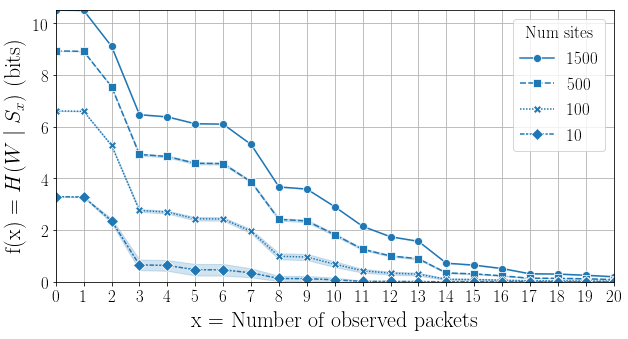

In [410]:
# initialize graph
fig, ax = plt.subplots(figsize=(10,5))
FINAL_SITES = [10, 100, 500, 1500]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.tick_params(labelsize=17)

max_packet=21
data = all_entropies_df[all_entropies_df.sites.isin(FINAL_SITES) & (all_entropies_df.pkt < max_packet)]
sns.lineplot(x='pkt', y='value', style='sites', data=data, markers=["o", "s", "X", "D"], ci="sd",
             style_order=FINAL_SITES[::-1], dashes=True, ax=ax, markersize=8)


leg = plt.legend(FINAL_SITES[::-1], fontsize=17)
leg.set_title('Num sites',prop={'size': 17})

plt.xticks(range(POSITIONS))
plt.grid(True)


# format graph
plt.xlabel('x = Number of observed packets', fontsize=22)
plt.ylabel('f(x) = $H(W\mid S_x)$ (bits)', fontsize=22)

plt.xlim((0, max_packet-1))
plt.ylim((0, np.max(all_entropies_df.value)))
plt.savefig('cond_entropy.pdf', bbox_inches="tight")

### Entropies for  1000 packets (the entropy should have converged)

In [151]:
df.num_pkts.describe()

count    90000.000000
mean        96.083267
std        117.002571
min          4.000000
25%         34.000000
50%         58.000000
75%        110.000000
max       1522.000000
Name: num_pkts, dtype: float64

In [154]:
# Compute entropies for different sites
NSITES = [10, 100, 500, 1500]
POSITIONS = 1000
SAMPLES = 10

def avg_entropies(i):
    entropies = np.zeros(SAMPLES)
    for k in xrange(SAMPLES):
        # select a random sample of i sites
        classes = df.class_label.unique()
        selected = np.random.choice(classes, i, replace=False)
        df_sel = df[df.class_label.isin(selected)].copy()
        entropies[k] = ProbabilityModel(df_sel, l=POSITIONS+1).cond_entropy()
    #avg_entropies = np.mean(entropies, axis=0)
    return entropies

# multiprocessing
p = Pool(len(NSITES))
all_entropies = p.map(avg_entropies, NSITES)

In [177]:
df = pd.DataFrame(np.array(all_entropies).transpose(), columns=NSITES).melt()
stats = df.groupby(['variable']).describe().xs('value', axis=1, drop_level=True)
display(stats)
stats['mean']

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
10,10.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
100,10.0,0.006102,5.225586e-03,0.000667,0.001297,0.005380,0.009775,0.016190
500,10.0,0.034134,5.008156e-03,0.023367,0.033083,0.033559,0.036570,0.042026
1500,10.0,0.090266,1.462847e-17,0.090266,0.090266,0.090266,0.090266,0.090266


variable
10      0.000000
100     0.006102
500     0.034134
1500    0.090266
Name: mean, dtype: float64

### Distribution of domain lengths

Sum: 1500
Num different lengths: 35


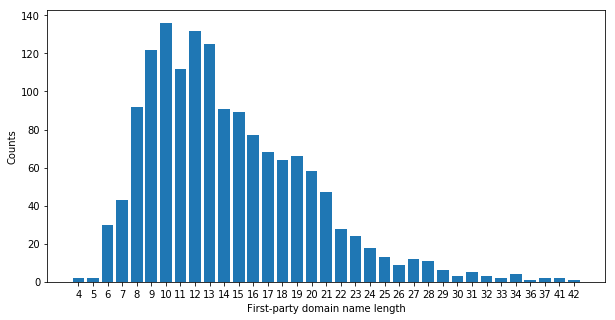

In [27]:
# how does entropy look for anonymity sets based on the length of the first-party domain?
df['domain_name'] = df.class_label.apply(lambda x: url(int(x)))
domains = df[['class_label', 'domain_name']].drop_duplicates()
domains['domain_length'] = df.domain_name.apply(len)
anon_sets = domains.groupby('domain_length').domain_name.count().reset_index().rename(columns={'domain_name': 'counts'})

plt.figure(figsize=(10,5))
plt.bar(map(str, anon_sets.domain_length), anon_sets.counts)
plt.xlabel('First-party domain name length')
plt.ylabel('Counts')

print "Sum:", sum(anon_sets.counts)
print "Num different lengths:", len(domains.domain_length.unique())

count    90000.000000
mean        94.894022
std        115.487476
min          4.000000
25%         34.000000
50%         58.000000
75%        109.000000
max       1482.000000
Name: lengths, dtype: float64

Text(0,0.5,'Counts')

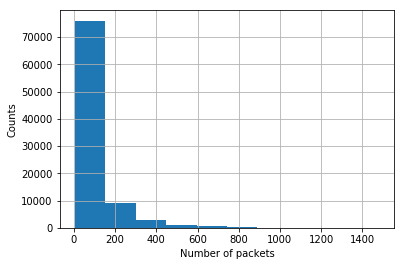

In [28]:
# number of packets distribution
num_pkts = df.lengths.apply(len)
num_pkts.hist()
display(num_pkts.describe())
plt.xlabel('Number of packets')
plt.ylabel('Counts')

In [29]:
print "- Entropy domain length distribution:", stats.entropy(anon_sets.counts, base=2)

only3 = df.copy()
only3['lengths'] = df.lengths.apply(lambda x: x[3])
pkt_size = only3.groupby('lengths').class_label.count().reset_index().rename(columns={'class_label': 'counts'})
print "- Entropy of packet 3:", stats.entropy(pkt_size[pkt_size.lengths > 0].counts, base=2)

until3 = df.copy()
until3['lengths'] = df.lengths.apply(lambda x: tuple(x[:3]))
pkt_size = until3.groupby('lengths').class_label.count().reset_index().rename(columns={'class_label': 'counts'})
print "- Entropy of packets 0, 1, 2, 3:", stats.entropy(pkt_size.counts, base=2)

only3 = df.copy()
only3['lengths'] = df.lengths.apply(lambda x: [x[3]])
Monly3 = ProbabilityModel(only3)
print "- Conditional entropy of domains given packet 3:", Monly3.cond_entropy()

M3 = ProbabilityModel(df, l=4)
print "- Conditional entropy of domains given packets 0, 1, 2, 3:", M3.cond_entropy()

- Entropy domain length distribution: 4.32808349068
- Entropy of packet 3: 3.92705114394
- Entropy of packets 0, 1, 2, 3: 3.54037247742
- Conditional entropy of domains given packet 3: 7.98851136511
- Conditional entropy of domains given packets 0, 1, 2, 3: 6.5191423735


In [30]:
# get fourth packet sizes
only3_lengths = only3[~only3.lengths.isin([(33.0, ), (-37.0,), (-33.0,), (-64.0,), (94.0,)])].lengths

In [31]:
# counts for fourth packet
only3 = df.copy()
only3['lengths'] = df.lengths.apply(lambda x: int(x[3]))
counts = list(only3.groupby('lengths').count()['date'])
counts = np.array(counts) / (1.0 * sum(counts))

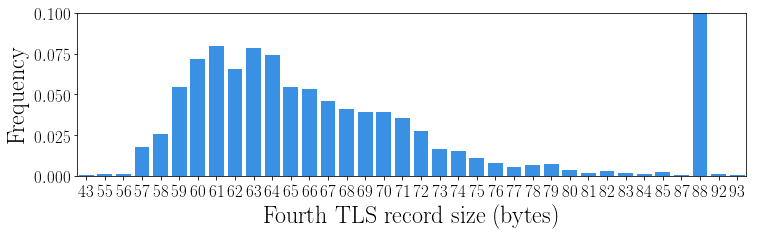

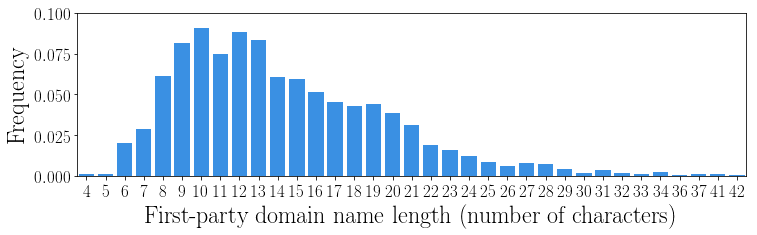

In [32]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

only3 = df.copy()
only3['lengths'] = df.lengths.apply(lambda x: int(x[3]))
true_lengths = only3[~only3.lengths.isin([33, -37, -33, -64, 94])].copy()
size_counts = true_lengths.groupby('lengths').domain_name.count().reset_index().rename(columns={'domain_name': 'counts'})

plt.figure(figsize=(12,3))
plt.tick_params(labelsize=17)
plt.ylim((0, 0.1))
size_counts = size_counts[size_counts.counts > 15]
size_counts['counts'] = np.array(size_counts.counts) / float(size_counts.counts.sum())
sns.barplot(x="lengths", y="counts", data=size_counts, color='dodgerblue')
plt.xlabel('Fourth TLS record size (bytes)', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.savefig('hist_fourth_packet.pdf', bbox_inches="tight")

## ------------------------

df['domain_name'] = df.class_label.apply(lambda x: url(int(x)))
domains = df[['class_label', 'domain_name']].drop_duplicates()
domains['domain_length'] = df.domain_name.apply(len)
anon_sets = domains.groupby('domain_length').domain_name.count().reset_index().rename(columns={'domain_name': 'counts'})

plt.figure(figsize=(12,3))
plt.tick_params(labelsize=17)
plt.ylim((0, 0.1))
#print anon_sets.counts
abs_dom_counts = anon_sets.copy()
anon_sets['counts'] = np.array(anon_sets.counts) / float(anon_sets.counts.sum())
sns.barplot(x="domain_length", y="counts", data=anon_sets, color='dodgerblue')
plt.xlabel('First-party domain name length (number of characters)', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.savefig('hist_domain_length.pdf', bbox_inches="tight")
plt.show()
#print len(size_counts.counts), len(anon_sets.domain_length)
#print entropy(size_counts.counts)
#print entropy(anon_sets.counts)
#print "Sum:", sum(size_counts.counts)
#print "Num different lengths:", len(domains.domain_length.unique())

# Entropies for pairs of sites

In [427]:
%%time

# Compute entropy for 2 manually picked sites
PARALLEL = False
SITES = [['facebook.com', 'nytimes.com'],
#         ['nytimes.com', 'google.com'],
         ['google.com', 'reddit.com'],
         ['t.co', 't.me'],
#         ['google.com', 'google.co.uk'],
         ['google.es', 'google.be'],
#         ['netflix.com', 'walmart.com']
         ]
POSITIONS = 38

    
def filt(x):
    indices = np.where(x < 0)[0]
    return indices[indices > 3][0]

first_inc, legends, all_entropies = [], [], []
for sites in SITES:
    selected = map(str, map(alexa_rank, sites))
    df_sel = df[df.class_label.isin(selected)].copy()
    legend = ', '.join(sites)
    results = [ProbabilityModel(df_sel, pos).cond_entropy()
               for pos in xrange(1, POSITIONS + 1)]
    legends.append(legend)
    all_entropies.append(results)
    first_inc.append(df_sel.lengths.apply(filt).median())

CPU times: user 15.6 s, sys: 940 ms, total: 16.5 s
Wall time: 15.7 s


In [428]:
all_entropies_df = pd.DataFrame(all_entropies).transpose()

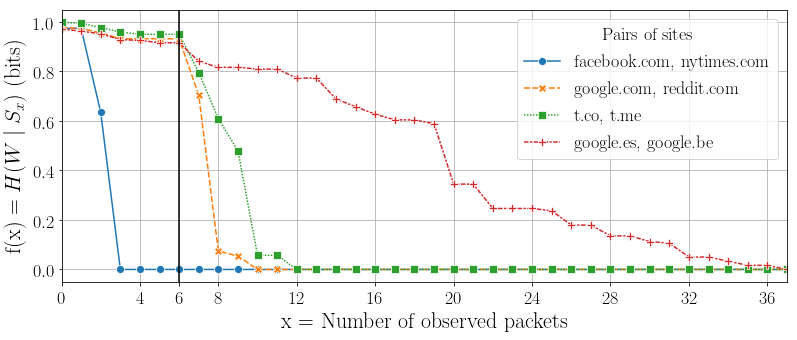

In [429]:
# initialize graph
#ax = plt.gca()

FINAL_SITES = [10, 100, 500, 1500]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(13,5))
plt.tick_params(labelsize=18)

sns.lineplot(data=all_entropies_df,
            markers=True, dashes=True, markersize=8)

# format graph
plt.xlabel('x = Number of observed packets', fontsize=22)
plt.ylabel('f(x) = $H(W\mid S_x)$ (bits)', fontsize=22)

leg = plt.legend(legends,
           loc='bottom center', ncol=1, fontsize=18)
leg.set_title('Pairs of sites', prop={'size': 18})

plt.xticks([0, 4] + [np.mean(first_inc)] + range(8, POSITIONS, 4))
plt.grid(True)

# plot first incoming packet
plt.axvline(x=np.mean(first_inc),  color="black")

plt.xlim((0, POSITIONS - 1))
#plt.ylim((0, np.max(all_entropies_df.value)))
plt.savefig('pair_sites.pdf', bbox_inches="tight")
plt.show()

Interestingly, nytimes.com and walmart.com require more packets to be distinguished. We have inspected the domains and they have a lots of resources with domains in common (google analytics, google ads, google services and other domains).